### SAで途中から再開するテンプレート
バッチサイズ分だけ並行して実施する

In [1]:
ex_num = "010"

In [2]:
import os
# 環境によって変更
os.chdir('/home/jovyan/work/notebook')

In [3]:
class CFG:
    path = "../model"    
    # path = "../../output"
    base_file_path = "../input/current_texts.csv"
    
    # 焼きなましのパラメータ
    temperature=1
    end_temperature=0.001
    cooling_rate=0.9999
    iteration=int(1e2)
    batch_size=8
    save_interval=10
    neighbor_types = ["swap", "insert", "inverse", "slide"]

In [4]:
import numpy as np
import pandas as pd
import os
import time
import csv

from tqdm.notebook import tqdm

import random
from typing import List, Callable
import itertools, math
from typing import List, Tuple

from utils import PerplexityCalculator
# 可視化用
import matplotlib.pyplot as plt

### データ読み込み

In [5]:
df = pd.read_csv(CFG.base_file_path)

In [6]:
sub_df = df.copy()
sub_df["best_value"] = 0

In [7]:
df

,sequence,0,score
0,0,reindeer game night puzzle from the night of t...,46.791573
1,1,from as kaggle cookie eat eggnog bake walk dri...,57.442316
2,2,grinch of scrooge and the the of the and from ...,40.732702
3,3,jingle yuletide merry season cheer cheer hohoh...,53.125458
4,4,jingle sleigh drive walk sing laugh jump cheer...,42.438114
5,5,the the of the of and to in is you that it we ...,41.617287
6,6,from the the of the of and to and is and as in...,45.175137
7,7,jingle yuletide merry holiday season we scroog...,44.301371


### 関数

In [8]:
def plot_score_and_temperature(scores_history, temp_history):
    # x 軸: イテレーション
    x = range(len(scores_history))
    
    # Figure と Axes を作成
    fig, ax1 = plt.subplots(figsize=(8,5))
    
    # スコア用の軸 (左)
    color_score = 'tab:blue'
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Score (Perplexity)', color=color_score)
    ax1.plot(x, scores_history, label='Score', color=color_score)
    ax1.tick_params(axis='y', labelcolor=color_score)
    
    # 温度用の軸 (右) : twinx で第二のY軸を作成
    ax2 = ax1.twinx()
    color_temp = 'tab:red'
    ax2.set_ylabel('Temperature', color=color_temp)
    ax2.plot(x, temp_history, label='Temperature', color=color_temp)
    ax2.tick_params(axis='y', labelcolor=color_temp)
    
    # タイトル等
    plt.title('Score & Temperature Transition')
    fig.tight_layout()
    plt.show()

In [9]:
# 2単語組み合わせ全てから最低スコアとなるペアを探す
def find_initial_pair(
    CFG,
    scorer,
    words
):
    best_score = float('inf')
    best_pair = None
    for i in range(len(words)):
        perms = []
        for j in range(i+1, len(words)):
            pair = [words[i], words[j]]
            perms.append(" ".join(pair))
        
        scores = scorer.get_perplexity(perms, batch_size=CFG.batch_size)
        for j, perm in enumerate(perms):
            if scores[j] < best_score:
                best_score = scores[j]
                best_pair = perm.split(" ")
                
                # print(f"best_score: {best_score}, best_pair: {best_pair}")
     
    return best_pair, best_score

In [10]:
# 文字の順番をランダムにして、返す
def shuffle_initialize(
    scorer,
    words
):
    random.shuffle(words)
    return words, scorer.get_perplexity([" ".join(words)], batch_size=1)[0]

In [11]:
# 文字列のファイルからコストを最小化する文字列を生成する
def greedy_add_initialize(
    CFG,
    scorer,
    initial_words: list
):
    
    # 全単語
    candidates = initial_words[:]

    print("candidates:", candidates)
    print("-----初期配置の組み合わせ計算開始-----")
    # 初期配置を求める
    initial, initial_score = find_initial_pair(
        CFG,
        scorer,
        candidates
    )
    print("-----初期配置の組み合わせ計算終了-----")
    for w in initial:
        candidates.remove(w)

    print("initial:", initial, initial_score)
    current_order = initial[:]

    print("-----貪欲法での挿入開始-----")
    # 貪欲に残りを挿入
    while candidates:
        best_score = float('inf')
        best_word = None
        best_pos = None

        # 残っている単語それぞれについて
        for w in candidates:
            # current_orderのあらゆる挿入位置を試す
            # 挿入位置は0からlen(current_order)まで
            
            perms = []
            for pos in range(len(current_order) + 1):
                new_order = current_order[:pos] + [w] + current_order[pos:]
                perms.append(" ".join(new_order))
                
            scores = scorer.get_perplexity(perms, batch_size=CFG.BATCH_SIZE)
                
            for pos in range(len(current_order) + 1):
                if scores[pos] < best_score:
                    best_score = scores[pos]
                    best_word = w
                    best_pos = pos
                    
                    # print("best_word:", best_word, best_score)
        
        # best_wordをbest_posに挿入
        current_order.insert(best_pos, best_word)
        candidates.remove(best_word)
        print("current_order:", current_order, best_score)
    print("-----貪欲法での挿入終了-----")
    
    best_score = scorer.get_perplexity([" ".join(current_order)], batch_size=1)[0]
    
    return current_order, best_score

In [12]:
def generate_neighbor(sequence, neighbor_type='swap'):
    """
    sequence: list of words
    neighbor_type: str, 近傍生成の種類 ('swap', 'insert', etc.)
    """
    new_seq = sequence[:]
    length = len(new_seq)

    if neighbor_type == 'swap':
        # ランダムに2つの位置を選んで入れ替える
        a, b = random.sample(range(length), 2)
        new_seq[a], new_seq[b] = new_seq[b], new_seq[a]

    elif neighbor_type == 'insert':
        # ある単語を抜き出し、別の位置に挿入する
        idx = random.randint(0, length - 1)
        word = new_seq.pop(idx)
        new_pos = random.randint(0, length - 1)
        new_seq.insert(new_pos, word)

    elif neighbor_type == 'shuffle_segment':
        # ランダムな部分区間を決めてシャッフル
        start = random.randint(0, length - 2)
        end = random.randint(start + 1, length - 1)
        segment = new_seq[start:end+1]
        random.shuffle(segment)
        new_seq[start:end+1] = segment

    elif neighbor_type == 'reverse_segment':
        # ランダムな部分区間を決めて反転
        start = random.randint(0, length - 2)
        end = random.randint(start + 1, length - 1)
        segment = new_seq[start:end+1]
        new_seq[start:end+1] = list(reversed(segment))

    # 他にも様々な近傍操作を追加可能

    return new_seq

In [20]:
def search_annealing(
    scorer,
    initial_sequences,
    temperature: float = 1.0,
    end_temperature: float = 0.01,
    cooling_rate: float = 0.999,
    iteration: int = 1000,
    batch_size: int = 10,
    save_interval: int = 1000,
    neighbor_types: list = None
):
    """
    焼きなまし法による探索

    Parameters
    ----------
    CFG: 設定用（必要に応じて）
    scorer: perplexityを計算できるオブジェクト
    initial_sequences: 初期の単語リスト
    temperature: 開始時の温度
    cooling_rate: 温度の減少率
    iteration: 探索の反復回数
    batch_size: 1ステップで生成する近傍候補の数
    neighbor_types: 近傍生成の種類を指定するリスト
    """
    if neighbor_types is None:
        neighbor_types = ['swap', 'insert', 'shuffle_segment', 'reverse_segment']

    texts = [" ".join(seq) for seq in initial_sequences]
    scores = scorer.get_perplexity(texts, batch_size=batch_size)

    # スコア推移を記録するリスト
    scores_history = []
    temp_history = []
    
    # 現在の状態を持つリスト
    current_seqs = []
    current_scores = []
    
    # 初期解の生成
    for i in range(CFG.batch_size):
        print("current_seq:", initial_sequences[i])
        print("current_score:", scores[i])
        current_seqs.append(initial_sequences[i])
        current_scores.append(scores[i])
    
    idx = np.argmin(current_scores)
    best_score = current_scores[idx]
    best_seq = current_seqs[idx]
    print("best_score:", best_score)
    print("best_seq:", best_seq)
            
        
    for itr in tqdm(range(iteration)):
        # 記録（ループの冒頭 or 最後のどちらでもOK）
        scores_history.append(current_scores[0])
        temp_history.append(temperature)
        
        # 近傍候補をまとめて生成
        neighbor_candidates = []
        for i in range(CFG.batch_size):
            # 近傍操作の種類をランダムに選ぶ
            n_type = random.choice(neighbor_types)
            neighbor_seq = generate_neighbor(current_seqs[i], n_type)
            neighbor_candidates.append(neighbor_seq)

        
        # まとめてスコアを計算（GPUを活用）
        texts = [" ".join(seq) for seq in neighbor_candidates]
        # print("texts:", texts)
        
        scores = scorer.get_perplexity(texts, batch_size=batch_size)
        # print("scores:", scores)
        
        # 候補の中から1つを焼きなまし法の確率的受容ルールで選ぶ
        for i, (cand_seq, cand_score) in enumerate(zip(neighbor_candidates, scores)):
            delta = cand_score - current_scores[i]
            accept_prob = math.exp(-delta / temperature) if delta > 0 else 1.0
                
            # スコアが良ければ必ず受容
            if (itr==0) or (random.random() < accept_prob):
                current_scores[i] = cand_score
                current_seqs[i] = cand_seq

        # ベストの更新
        # currnet_scoresのリストの最小値を取得
        if np.min(current_scores) < best_score:
            # current_scoresの最小値のインデックスを取得
            idx = np.argmin(current_scores)
            
            best_score = current_scores[idx]
            best_seq = current_seqs[idx]
            print(f"iter {itr}: best_score: {best_score}")
            print("best_seq:", best_seq)

        # 温度を下げる
        if itr % 10 == 0:
            temperature *= cooling_rate
        
        if itr % save_interval == 0:
            print(f"iter :{itr}, best_score: {best_score}, temperature: {temperature}")

            # current_seqsを結合して文字列保存
            current_seqs_text = [" ".join(seq) for seq in current_seqs]
            # current_seqsとcurrent_scoresのリストをdfとして保存
            df = pd.DataFrame(current_seqs_text)
            df["score"] = current_scores
            
            # indexとなっていたものをsequencre列に変更
            df = df.reset_index()
            df = df.rename(columns={"index": "sequence"})
            
            df.to_csv(f"{CFG.path}/out/current_texts_{ex_num}.csv", index=False)
        if temperature < end_temperature:
            break
        
    return best_seq, best_score, scores_history, temp_history

In [24]:
def search_optimal_permutation(
    CFG,
    id: int, 
    scorer
):
    
    df = pd.read_csv(CFG.base_file_path)
    # sequence列を削除して0列をsequence列にする
    df = df.drop(columns=["sequence"])
    df = df.rename(columns={"0": "sequence"})

    # dfのsequence列をリストに変換
    initial_sequences = df["sequence"].tolist()
    # initial_sequencesをスペースで区切ってリストに変換
    initial_sequences = [seq.split(" ") for seq in initial_sequences]
    
    start = time.time()
    print("---------焼きなまし処理開始---------")
    best_sequence, best_score, scores_history, temp_history = search_annealing(
        scorer=scorer,
        initial_sequences=initial_sequences,
        temperature=CFG.temperature,
        end_temperature=CFG.end_temperature,
        cooling_rate=CFG.cooling_rate,
        iteration=CFG.iteration,
        batch_size=CFG.batch_size,
        save_interval=CFG.save_interval,
        neighbor_types=CFG.neighbor_types
    )
    print("---------焼きなまし処理終了---------")
    
    print(f"{id}th sample: {best_sequence}")
    print(f"Elapsed time: {time.time() - start:.2f} sec")
    print(f"best_score: {best_score}")
    
    plot_score_and_temperature(scores_history, temp_history)
    
    return best_sequence, best_score


In [25]:
# 文字列型にのみダブルクォーテーションを付ける関数
def add_quotes_to_strings(value):
    if isinstance(value, str):  # 文字列型の場合
        return f'"{value}"'
    return value  # それ以外はそのまま

In [16]:
# LOAD GEMMA SCORER
scorer = PerplexityCalculator(f'{CFG.path}/gemma_2_9b')

cuda


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


In [17]:
# scorer.clear_gpu_memory()

Processing
---------焼きなまし処理開始---------
current_seq: ['reindeer', 'game', 'night', 'puzzle', 'from', 'the', 'night', 'of', 'the', 'polar', 'beard', 'and', 'hohoho', 'and', 'peace', 'joy', 'wonder', 'wish', 'hope', 'dream', 'believe', 'laugh', 'relax', 'unwrap', 'give', 'cheer', 'eat', 'sleep', 'bake', 'sleigh', 'drive', 'walk', 'jump', 'visit', 'sing', 'yuletide', 'carol', 'merry', 'jingle', 'elf', 'workshop', 'chimney', 'fireplace', 'nutcracker', 'doll', 'snowglobe', 'ornament', 'advent', 'candle', 'wreath', 'poinsettia', 'holly', 'mistletoe', 'star', 'angel', 'magi', 'gifts', 'bow', 'kaggle', 'the', 'of', 'and', 'to', 'in', 'as', 'is', 'that', 'it', 'we', 'with', 'not', 'you', 'have', 'scrooge', 'grinch', 'naughty', 'nice', 'toy', 'workshop', 'chocolate', 'milk', 'eggnog', 'fruitcake', 'gingerbread', 'cookie', 'peppermint', 'candy', 'stocking', 'fireplace', 'chimney', 'wrapping', 'paper', 'greeting', 'card', 'ornament', 'decorations', 'family', 'holiday', 'season', 'cheer']
current_sc

  0%|          | 0/100 [00:00<?, ?it/s]

iter :0, best_score: 40.65322322588273, temperature: 0.9999
iter :10, best_score: 40.65322322588273, temperature: 0.9998000100000001
iter :20, best_score: 40.65322322588273, temperature: 0.9997000299990001
iter :30, best_score: 40.65322322588273, temperature: 0.9996000599960002
iter :40, best_score: 40.65322322588273, temperature: 0.9995000999900007
iter :50, best_score: 40.65322322588273, temperature: 0.9994001499800017
iter :60, best_score: 40.65322322588273, temperature: 0.9993002099650037
iter :70, best_score: 40.65322322588273, temperature: 0.9992002799440072
iter :80, best_score: 40.65322322588273, temperature: 0.9991003599160128
iter :90, best_score: 40.65322322588273, temperature: 0.9990004498800211
---------焼きなまし処理終了---------
0th sample: ['grinch', 'of', 'scrooge', 'and', 'the', 'the', 'of', 'the', 'and', 'from', 'and', 'to', 'as', 'in', 'is', 'that', 'it', 'we', 'with', 'not', 'you', 'have', 'holiday', 'sleep', 'eat', 'drive', 'walk', 'jump', 'sing', 'laugh', 'cheer', 'yuleti

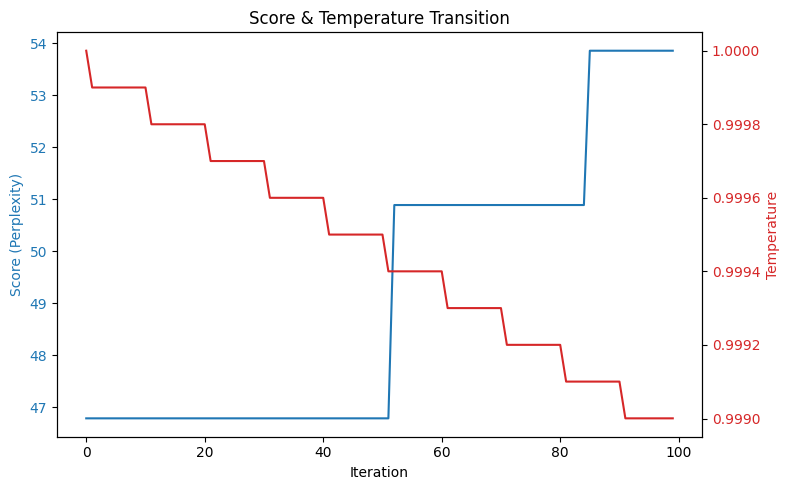

Best sequence: ['grinch', 'of', 'scrooge', 'and', 'the', 'the', 'of', 'the', 'and', 'from', 'and', 'to', 'as', 'in', 'is', 'that', 'it', 'we', 'with', 'not', 'you', 'have', 'holiday', 'sleep', 'eat', 'drive', 'walk', 'jump', 'sing', 'laugh', 'cheer', 'yuletide', 'merry', 'season', 'cheer', 'carol', 'jingle', 'visit', 'family', 'relax', 'unwrap', 'give', 'toy', 'doll', 'game', 'puzzle', 'peace', 'joy', 'wonder', 'wish', 'hope', 'believe', 'dream', 'night', 'night', 'naughty', 'nice', 'hohoho', 'advent', 'candle', 'star', 'angel', 'magi', 'gifts', 'decorations', 'greeting', 'card', 'wrapping', 'paper', 'bow', 'ornament', 'wreath', 'holly', 'mistletoe', 'poinsettia', 'candy', 'peppermint', 'gingerbread', 'cookie', 'bake', 'chocolate', 'milk', 'eggnog', 'fruitcake', 'ornament', 'stocking', 'nutcracker', 'snowglobe', 'sleigh', 'reindeer', 'workshop', 'workshop', 'polar', 'beard', 'elf', 'chimney', 'chimney', 'fireplace', 'fireplace', 'kaggle']
Best score: 40.65322322588273


In [26]:
print(f"Processing")
best_sequence, best_score = search_optimal_permutation(
    CFG,
    id=0,
    scorer=scorer,
)

print("Best sequence:", best_sequence)
print("Best score:", best_score)
# sub_df.loc[i, "best_value"] = best_score
# sub_df.loc[i, "text"] = " ".join(best_sequence)

